# 2. Playing around

Author: Arianna Basile, MRC Toxicology Unit, University of Cambridge

__________________________________________________________________________________________________________________
In this tutorial:
<ul>
    <li>You will change the growth medium of your reconstruction (2.1) </li>
    <li>Perform gene essentiality analysis on different conditions (2.2)</li>
    <li>Case study: simulating the Carbtree effect in yeast (2.3) </li>
</ul>


In [1]:
#import the needed packages
import cobra

#enable autocompleting with tab
%config Completer.use_jedi = False


In [2]:
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")

## 2.1 Growth medium

The availability of nutrients has a major impact on metabolic fluxes and cobrapy provides some helpers to manage the exchanges between the external environment and your metabolic model. In experimental settings the “environment” is usually constituted by the growth medium, ergo the concentrations of all metabolites and co-factors available to the modeled organism. However, constraint-based metabolic models only consider fluxes. Thus, you can not simply use concentrations since fluxes have the unit mmol / [gDW h] (concentration per gram dry weight of cells and hour).

Also, you are setting an upper bound for the particular import flux and not the flux itself. There are some crude approximations. For instance, if you supply 1 mol of glucose every 24h to 1 gram of bacteria you might set the upper exchange flux for glucose to 1 mol / [1 gDW * h] since that is the nominal maximum that can be imported. There is no guarantee however that glucose will be consumed with that flux. Thus, the preferred data for exchange fluxes are direct flux measurements as the ones obtained from timecourse exa-metabolome measurements for instance.

So how does that look in COBRApy? The current growth medium of a model is managed by the medium attribute.

In [3]:
medium=model_yeast.medium
medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

This will return a dictionary that contains the upper flux bounds for all active exchange fluxes (the ones having non-zero flux bounds). Right now we see that we have enabled aerobic growth. 
Let's optimize to check the growth in the given medium.

In [4]:
model_yeast.optimize()

,fluxes,reduced_costs
CITtcp,0.000000,0.000000e+00
13BGH,0.000000,-4.751566e-02
13BGHe,0.000000,0.000000e+00
13GS,0.326670,0.000000e+00
16GS,0.000000,0.000000e+00
...,...,...
PYDXO,0.000000,0.000000e+00
PYK,17.721990,1.040834e-17
PYNP2r,0.000000,1.387779e-17
PYR5CDm,0.000000,0.000000e+00


You can modify a growth medium of a model by assigning a dictionary to model.medium that maps exchange reactions to their respective upper import bounds. Let's edit the medium to have ethanol as carbon source, instead of glucose

In [5]:
model_yeastv2=model_yeast.copy() #we are making a copy of the original model and editing the copy
medium = model_yeastv2.medium
medium["EX_glc__D_e"] = 0
medium["EX_etoh_e"] = 1.0
model_yeastv2.medium = medium

model_yeastv2.medium

{'EX_etoh_e': 1.0,
 'EX_fe2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

As we can see, the glucose in our medium has been replaced by ethanol. Let's check how it influences the growth rate.

In [6]:
model_yeastv2.optimize()

model_yeastv2.objective.value

0.027542115993883863

The growth rate is reduced


Summing up, we have the same metabolic reconstruction (iMM904) in two different conditions using different carbon sources determining two different metabolic models (model_yeast and model_yeastv2).

## 2.2 Gene essentiality

A gene is considered essential if restricting the flux of all reactions that depend on it to zero causes the objective, e.g., the growth rate, to also be zero, below the threshold, or infeasible.

Now we will use the function find_essential_genes to find essential genes in both conditions, extract the IDs of the genes, and compare the two lists. Can you do it by yourself? 

In [14]:
ess_genesv2=cobra.flux_analysis.variability.find_essential_genes(model_yeastv2)
id_ess_genesv2=[gene.id for gene in ess_genesv2]

In [15]:
ess_genes=cobra.flux_analysis.variability.find_essential_genes(model_yeast)
id_ess_genes=[gene.id for gene in ess_genes]

In [16]:
len(id_ess_genesv2)
len(id_ess_genes)


154
110


In [17]:
a=list(set(id_ess_genesv2) & set(id_ess_genes))
len(a)

110

In [18]:
list(set(id_ess_genesv2) - set(id_ess_genes))

['YHR051W',
 'YDR298C',
 'YHR001W_A',
 'YFR033C',
 'Q0250',
 'Q0045',
 'YJR121W',
 'YGL187C',
 'YER065C',
 'YEL024W',
 'Q0130',
 'YPL078C',
 'Q0085',
 'YPR191W',
 'YDL067C',
 'YDR529C',
 'Q0275',
 'YDR377W',
 'Q0105',
 'YLR038C',
 'YBL099W',
 'YPL262W',
 'Q0080',
 'YGL191W',
 'YBL045C',
 'YDR050C',
 'YML081C_A',
 'YDL181W',
 'YMR256C',
 'YLR295C',
 'YCR012W',
 'YOR065W',
 'YDL004W',
 'YBR039W',
 'YLL041C',
 'YKL016C',
 'YKL060C',
 'YBR196C',
 'YLR395C',
 'YGR183C',
 'YLR377C',
 'YKR097W',
 'YJL166W',
 'YPL271W']

In [19]:
list(set(id_ess_genes) - set(id_ess_genesv2))

[]

### Exercises

1) Why there are more essential genes for growth on ethanol than for growth on glucose? 

2) What are the features of the genes essential only for growth on ethanol?

## 2.3 Simulating the Crabtree effect 



Yeast central carbon metabolic pathways: all short-term Crabtree positive yeasts possess an upregulated aerobic (blue) and anaerobic (red) glycolytic pathway, even under fully aerobic conditions, when energy and carbon-source is limiting. At low glucose uptake rates, yeasts cells are purely respiring and there is a carbon-flux only through glycolysis (GF) and respiration (RF). Upon a sudden glucose excess condition (glucose pulse), the glycolytic flux will exceed the respiratory flux, which results in a fermentative flux (FF) and ethanol production. In other words, it appears as if slowly dividing short-term Crabtree positive cells, with little food around are already equipped with a strong energy producing apparatus, for rapid glucose consumption and energy production.

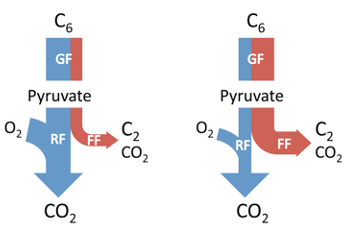
(Adapted from <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0116942">Hagman and Piškur, 2015</a>)

To simulate the Carbtree effect, we consider a fixed amount of glucose and different concentrations of oxygen in our medium. 

In [33]:
model_yeastv3=model_yeast.copy()

oxygen_concentrations=range(5,400,10)
oxygen_concentrations = [ x / 100 for x in oxygen_concentrations]
etoh_prod=[]

for conc in oxygen_concentrations:
    medium = model_yeastv3.medium
    medium["EX_glc__D_e"] = 15
    medium["EX_o2_e"]=conc
    model_yeastv3.medium = medium
    opt=model_yeastv3.optimize()
    etoh_prod.append(opt.fluxes["EX_etoh_e"])


Now we can plot our results :)

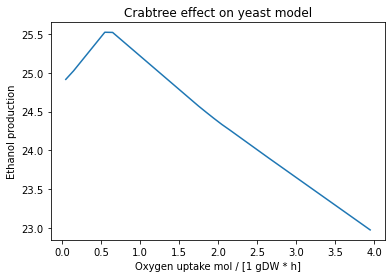

In [34]:
import matplotlib.pyplot as plt
x_axis=oxygen_concentrations
y_axis=etoh_prod
plt.plot(x_axis, y_axis)
plt.title('Crabtree effect on yeast model')
plt.xlabel('Oxygen uptake mol / [1 gDW * h]')
plt.ylabel('Ethanol production')
plt.show()

In [1]:
#if you want you can try similar analyses using different carbon sources, e.g. D-mannose
#type your code here, solutions in the html

END :)
